# Udacity Self Driving Car Nanodegree
# Project 3 - Behavioural Cloning

By James Marshall

In [1]:
##Checklist

##Get AWS working
##Normalise Steering Values
##FitGenerator get better samples_per_epoch and nb_....

## Imports

In [2]:
import csv
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint, Callback

print("done")

Using TensorFlow backend.


done


## Get Images from files and augment them

In [3]:
samples = []
with open('mydata/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

        
image_paths = []
measurements = []
for line in samples:
    #Centre Image
    source_path = line[0]
    path, filename = os.path.split(source_path)
    current_path = 'C:\\Users\\James\\Documents\\GitHub\\CarND-Behavioral-Cloning-P3\\mydata\\IMG' + '\\' + filename
    current_path.strip()
    image_paths.append(current_path)
    measurements.append(float(line[3]))
    
    #Left Image
    source_path = line[1]
    path, filename = os.path.split(source_path)
    current_path = 'C:\\Users\\James\\Documents\\GitHub\\CarND-Behavioral-Cloning-P3\\mydata\\IMG' + '\\' + filename
    current_path.strip()
    image_paths.append(current_path)
    measurements.append(float(line[3]) + 0.25)
    #Right Image
    source_path = line[2]
    path, filename = os.path.split(source_path)
    current_path = 'C:\\Users\\James\\Documents\\GitHub\\CarND-Behavioral-Cloning-P3\\mydata\\IMG' + '\\' + filename
    current_path.strip()
    image_paths.append(current_path)
    measurements.append(float(line[3]) - 0.25)
    
print("done")

done


## Distribution of steering values

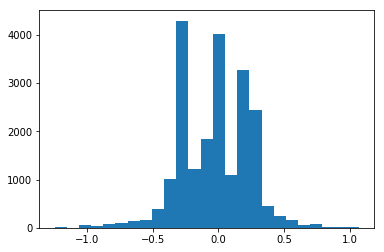

In [4]:
num_bins = 25
avg_samples_per_bin = len(measurements)/num_bins

hist, bins, _ = plt.hist(measurements, num_bins)
plt.show()

## Normalising Distribution

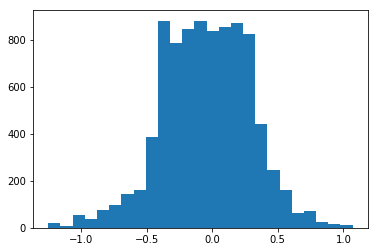

In [5]:
keep_probs = []
target = avg_samples_per_bin
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(measurements)):
    for j in range(num_bins):
        if measurements[i] > bins[j] and measurements[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
image_paths = np.delete(image_paths, remove_list, axis=0)
measurements = np.delete(measurements, remove_list)

# print histogram again to show more even distribution of steering angles
plt.hist(measurements, num_bins)
plt.show()


## Image Preprocessing

In [6]:
def preprocess_image(img):
    #Apply a Gaussian Blur
    new_img = cv2.GaussianBlur(img, (3,3), 0)
    #Following NVidias advice, resize to 66x200x3
    #Crop first
    new_img = img[50:140,:,:]
    new_img = cv2.resize(new_img, (200, 66), interpolation = cv2.INTER_AREA)
    #Again following NVidias advice on the model being used, convert to YUV colour space
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img

print("done")

done


## Random Distortion

In [7]:
#Randomly distort the training images to help the model generalise better
def random_distort(img):
    #Convert to float to allow distortion
    new_img = img.astype(float)
    
    #Adjust brightness of image
    value = np.random.randint(-28, 28)
    #valid_mask will be false if the brightness adjustment would set the value out of the (0, 255) range
    #If false, the brightness will not be adjusted
    if value > 0:
        valid_mask = (new_img[:,:,0] + value) > 255
    else:
        valid_mask = (new_img[:,:,0] + value) < 0
    new_img[:,:,0] += np.where(valid_mask, 0, value)
    
    #Randomly shadow the image on a random portion of the image, defined by mid
    height ,width = new_img.shape[0:2]
    mid = np.random.randint(0, width)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:, 0:mid, 0] *= factor
    else:
        new_img[:, mid:width, 0] *= factor
    
    #Randomly shift the image horizontally and vertically
    height ,width = new_img.shape[0:2] #Redundant but helps for clarity
    horizon = 2*height / 5
    vertical = np.random.randint(-height/8, height/8)
    src = np.float32([[0, horizon], [width, horizon], [0, height], [width, height]])
    dst = np.float32([[0, horizon+vertical], [width, horizon+vertical], [0, height], [width, height]])
    M = cv2.getPerspectiveTransform(src, dst)
    new_img = cv2.warpPerspective(new_img, M, (width, height), borderMode=cv2.BORDER_REPLICATE)
    
    #Remember to return the image as a uint8
    return new_img.astype(np.uint8)

print("done")

done


## Split training and validation data

In [8]:
image_path_train, image_path_valid, measurements_train, measurements_valid = train_test_split(image_paths, measurements, 
                                                                                                test_size=0.2)
print("done")

done


## Generator

In [9]:
def generator(image_paths, measurements, batch_size=32, valid_flag=False):

    image_paths, measurements = shuffle(image_paths, measurements)
    X_train = []
    y_train = []
    
    while 1:
        
        for i in range(len(measurements)):
            
            image = cv2.imread(image_paths[i])
            image = preprocess_image(image)
            measurement = measurements[i]
            
            if valid_flag == False:
                    image = random_distort(image)
            
            X_train.append(image)
            y_train.append(measurement)
            
            if len(X_train) == batch_size:
                yield (np.array(X_train), np.array(y_train))
                X_train = []
                y_train = []
                image_paths, measurements = shuffle(image_paths, measurements)
                
            #If the steering angle is significant (> 0.33), flip the image and add it to the training set
            if abs(measurement)  > 0.33:
                flipped_image = cv2.flip(image, 1)
                measurement *= -1
                X_train.append(flipped_image)
                y_train.append(measurement)
                if len(X_train) == batch_size:
                    yield (np.array(X_train), np.array(y_train))
                    X_train = []
                    y_train = []
                    image_paths, measurements = shuffle(image_paths, measurements)

                
print("done")

done


In [10]:
train_generator = generator(image_path_train, measurements_train, batch_size=32, valid_flag=False)
validation_generator = generator(image_path_valid, measurements_valid, batch_size=32, valid_flag=True)

print("done")

done


## Keras Imports

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D, Reshape
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.backend import tf

print("done")

done


In [12]:
model = Sequential()
model.add(Lambda(lambda x: x/ 255.0 - 0.5, input_shape=(66,200,3)))
#Conv 1
model.add(Convolution2D(24, (5, 5)))
model.add(Activation('elu'))
#Conv 2
model.add(Convolution2D(36, (5, 5)))
model.add(Activation('elu'))
#Conv 3
model.add(Convolution2D(48, (3, 3)))
model.add(Activation('elu'))
#Conv 4
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('elu'))
#Conv 5
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('elu'))
#Fully Connected
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.fit_generator(train_generator, samples_per_epoch= 50, 
                    validation_data=validation_generator, nb_val_samples=5, nb_epoch=3)

model.save('model.h5')

print("done")

C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=50, epochs=3, validation_steps=5)`


Epoch 1/3
50/50 [==============================] - 329s 7s/step - loss: 14.2305 - val_loss: 0.5778
Epoch 2/3
50/50 [==============================] - 332s 7s/step - loss: 3.8268 - val_loss: 0.6850
Epoch 3/3
50/50 [==============================] - 342s 7s/step - loss: 2.6943 - val_loss: 0.4960
done
